# Final Project Rough Draft

## Introduction

### Background and Data
Pulsars radiate two rotating narrow beams of light in different directions at regular rapid intervals (Cofield, 2016). The beams of light spin and sweep across the sky instead of pointing in a single direction because they are not aligned with the pulsar's axis of rotation (Cofield, 2016). From earth, pulsars appear to be flickering stars, despite the light from the beams being steady because of the spinning that occurs. Pulsars are around the size of a city and are believed to be neutron stars, meaning they form when a star’s core collapses upon itself in a supernova (Hobbs, 2020). 


We are using the Predicting Pulsar Star dataset retrieved from Kaggle. Each observation in the dataset contains the mean, standard deviation, skewness, excess kurtosis of the integrated profile and DM-SNR Curve of each star, and each star’s observed class. The integrated profile of a pulsar is the folded signal array obtained with respect to its rotational period and signal (Liu, 2017). The shape is unique to each pulsar and can be used to distinguish pulsars from one another. The other four are concerning statistics for the DM-SNR Curve. DM-SNR stands for Dispersion Measure (how the signal of a star broadens) of the Signal to Noise Ratio (Swinburne University of Technology, 2020; The University of Sheffield, n.d.). Noise will appear in all astronomical measurements, limiting the precision of a measurement made from data. So, the Signal to Noise ratio (ratio of the signal from an astronomical source to the noise) is calculated in an attempt to estimate the noise in observations to determine if observations will be adequate (The University of Sheffield, n.d.).


<img src="https://scx2.b-cdn.net/gfx/news/hires/pulsar.gif" style="<float: right; height: 20em">
Image Credit: Imagine the Universe! at NASA/GSFC

### Question
How well does the best variable combination from a star's integrated profile and DM-SNR Curve predict if a star is a pulsar?

## Methods
### Summary
Our methodology for finding the best predictors involves running each set of predictors on the training set and tuning for the best value of k.  The first four accuracy plots correspond to the performance with which the mean, standard deviation, kurtosis, and skewness pairs of the integrated profile and DM-SNR curve could predict the target class. From each plot we identified the best k value.
We also created two other models to test the accuracy of all the Integrated profile summary statistics and the DM-SNR curve summary statistics.

### Procedure
First, we read all of the required packages into R. Then, the kaggle data set was read in and assigned a name, and the column names were then shortened into human readable variables.

In [1]:
#Read packages into R
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally); library(gridExtra)
options(repr.matrix.max.rows = 6)

#Reading the dataset and shortening the column names
pulsar_base_data = read_csv("https://raw.githubusercontent.com/NicoRui/DSCI_100_Project/main/pulsar_data_train.csv", skip = 1,
                            col_names = c("mean_prof", "sd_prof", 
                                          "kurt_prof", "skew_prof", "mean_DMSNR",
                                          "sd_DMSNR","kurt_DMSNR","skew_DMSNR", "target_class")) %>% 
                    mutate(target_class = as_factor(target_class)) %>% 
                    mutate(target_class = fct_recode(target_class,
                                                    "non_pulsar" = '0',
                                                    "pulsar" = '1')) 
           
head(pulsar_base_data)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.449874,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.414652,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.508364,74.031324,non_pulsar
156.39844,48.86594,-0.2159886,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.405008,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.546051,112.131721,non_pulsar


A seed was set to ensure that the same result was obtained each time the processes were run. The data was then split into its respective pulsar training data and pulsar testing data.


In [2]:
#Splitting Data
set.seed(632)
pulsar_split = initial_split(pulsar_base_data, prop = 0.8, strata = target_class)
pulsar_train = training(pulsar_split)
pulsar_test = testing(pulsar_split)

#### Table 1 - Training Data

In [3]:
head(pulsar_train)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
121.15625,48.37297,0.3754847,-0.01316549,3.168896,18.39937,7.4498741,65.159298,non_pulsar
76.96875,36.17556,0.7128979,3.38871856,2.399666,17.57100,9.4146523,102.722975,non_pulsar
130.58594,53.22953,0.1334083,-0.29724164,2.743311,22.36255,8.5083638,74.031324,non_pulsar
84.80469,36.11766,0.8250128,3.27412537,2.790134,20.61801,8.4050084,76.291128,non_pulsar
121.00781,47.17694,0.2297081,0.09133623,2.036789,NA,9.5460511,112.131721,non_pulsar
79.34375,42.40217,1.0634129,2.24437669,141.641304,NA,-0.7008088,-1.200653,non_pulsar


#### Table 2 - Testing Data

In [4]:
head(pulsar_test)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
156.3984,48.86594,-0.21598860,-0.17129365,17.471572,NA,2.958066,7.197842,non_pulsar
83.9375,45.71272,0.74877682,1.34290171,1.747492,12.07058,11.838557,NA,non_pulsar
111.7109,46.57054,0.27286063,-0.06164600,2.139632,16.65571,9.353872,97.733760,non_pulsar
127.3281,45.33954,-0.02866461,-0.20653223,3.955686,26.25178,6.815905,46.623791,non_pulsar
108.7578,47.47084,0.23388338,-0.01183974,3.428930,22.80573,7.431087,58.339075,non_pulsar
117.6797,47.45704,0.21480140,-0.13550329,2.731605,21.99329,8.401669,71.587641,non_pulsar


Since there were several missing values (NAs) within the training and testing datasets, we dropped the rows that contained missing values. We then determined the distributional characteristics of all of the predictor variables.

In [5]:
# Table of some summary statistics for each variable
summary(pulsar_train)

#Pulsar train and test with no NAs
pulsar_train_noNA = drop_na(pulsar_train)
pulsar_test_noNA = drop_na(pulsar_test)

#Distributional Characteristics with no NAs
summary_train_distribution = pulsar_train_noNA %>% 
    group_by(target_class) %>% 
    summarize_all(list(mean = mean, sd = sd)) %>% 
    mutate(across(where(is.numeric), round, 3))

   mean_prof          sd_prof        kurt_prof         skew_prof      
 Min.   :  6.188   Min.   :24.77   Min.   :-1.7380   Min.   :-1.7919  
 1st Qu.:100.625   1st Qu.:42.30   1st Qu.: 0.0230   1st Qu.:-0.1856  
 Median :115.102   Median :46.93   Median : 0.2233   Median : 0.2062  
 Mean   :110.895   Mean   :46.51   Mean   : 0.4859   Mean   : 1.8416  
 3rd Qu.:127.203   3rd Qu.:51.02   3rd Qu.: 0.4769   3rd Qu.: 0.9523  
 Max.   :189.734   Max.   :91.81   Max.   : 8.0695   Max.   :68.1016  
                                   NA's   :1410                       
   mean_DMSNR          sd_DMSNR        kurt_DMSNR       skew_DMSNR      
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.945  
 1st Qu.:  1.9122   1st Qu.: 14.40   1st Qu.: 5.815   1st Qu.:  35.208  
 Median :  2.7860   Median : 18.44   Median : 8.465   Median :  83.310  
 Mean   : 12.9438   Mean   : 26.43   Mean   : 8.341   Mean   : 106.211  
 3rd Qu.:  5.3955   3rd Qu.: 28.33   3rd Qu.:10.728   3rd Qu.: 140.

#### Table 3 - Distributional Characteristics

In [6]:
head(summary_train_distribution)

target_class,mean_prof_mean,sd_prof_mean,kurt_prof_mean,skew_prof_mean,mean_DMSNR_mean,sd_DMSNR_mean,kurt_DMSNR_mean,skew_DMSNR_mean,mean_prof_sd,sd_prof_sd,kurt_prof_sd,skew_prof_sd,mean_DMSNR_sd,sd_DMSNR_sd,kurt_DMSNR_sd,skew_DMSNR_sd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
non_pulsar,116.716,47.316,0.209,0.388,8.970,23.246,8.914,115.468,17.586,6.156,0.335,0.998,24.857,16.744,4.313,110.374
pulsar,56.086,38.607,3.179,16.080,51.245,56.557,2.765,18.455,30.094,8.157,1.921,14.615,46.618,20.025,3.155,48.350


All of the predictor variables were standardized and upsampled.  Standardization was used to ensure variables using different scales would not be weighted in accordance to the size of the scale (i.e. a large-scale variable dominates the euclidean distance).  Upsampling was used to remove the class imbalance, which was roughly nine-to-one.


In [7]:
#Standardization of all predictor variables

pulsar_train_upsample_recipe = recipe(target_class~., data = pulsar_train_noNA) %>% 
        step_upsample(target_class, over_ratio = 1, skip = FALSE) %>% 
        prep()
pulsar_train_upsample = bake(pulsar_train_upsample_recipe, pulsar_train_noNA)

pulsar_recipe_train = recipe(target_class~., data = pulsar_train_upsample) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_train = bake(pulsar_recipe_train, pulsar_train_upsample)


pulsar_recipe_test = recipe(target_class~., data = pulsar_test_noNA) %>% 
                    step_scale(all_predictors()) %>% 
                    step_center(all_predictors()) %>% 
                    prep()
scaled_pulsar_test = bake(pulsar_recipe_test, pulsar_test_noNA)

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


#### Table 4 - Upsampled Target Class

In [98]:
group_by(scaled_pulsar_train, target_class) %>% summarize(n = n())

`summarise()` ungrouping output (override with `.groups` argument)



target_class,n
<fct>,<int>
non_pulsar,6711
pulsar,6711


#### Table 5 - Scaled Pulsar Training Data

In [99]:
head(scaled_pulsar_train)

mean_prof,sd_prof,kurt_prof,skew_prof,mean_DMSNR,sd_DMSNR,kurt_DMSNR,skew_DMSNR,target_class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.8900741,0.6460178,-0.6514908,-0.6371058,-0.6281189,-0.8591879,0.3270835,-0.02131540,non_pulsar
-0.2386530,-0.7985320,-0.4855848,-0.3762494,-0.6459383,-0.8922846,0.7297811,0.36139647,non_pulsar
1.1309464,1.2211844,-0.7705197,-0.6588888,-0.6379777,-0.7008429,0.5440298,0.06907591,non_pulsar
-0.0384915,-0.8053889,-0.4304579,-0.3850364,-0.6368930,-0.7705444,0.5228462,0.09209958,non_pulsar
0.5899317,1.5389328,-0.5582541,-0.6317833,-0.6367187,-0.8153520,0.7356491,0.30690514,non_pulsar
0.2221375,-0.3195683,-0.6652125,-0.5476717,-0.6373579,-0.8664446,0.4093396,0.03617379,non_pulsar


Four 2-D scatter plots were created using the standardized training data, and each plot contained either the mean, standard deviation, kurtosis, and skewness variables of the integrated profiles plotted against those of the DM-SNR curve. The blue data points represent non-pulsars, while the red represents the pulsars.



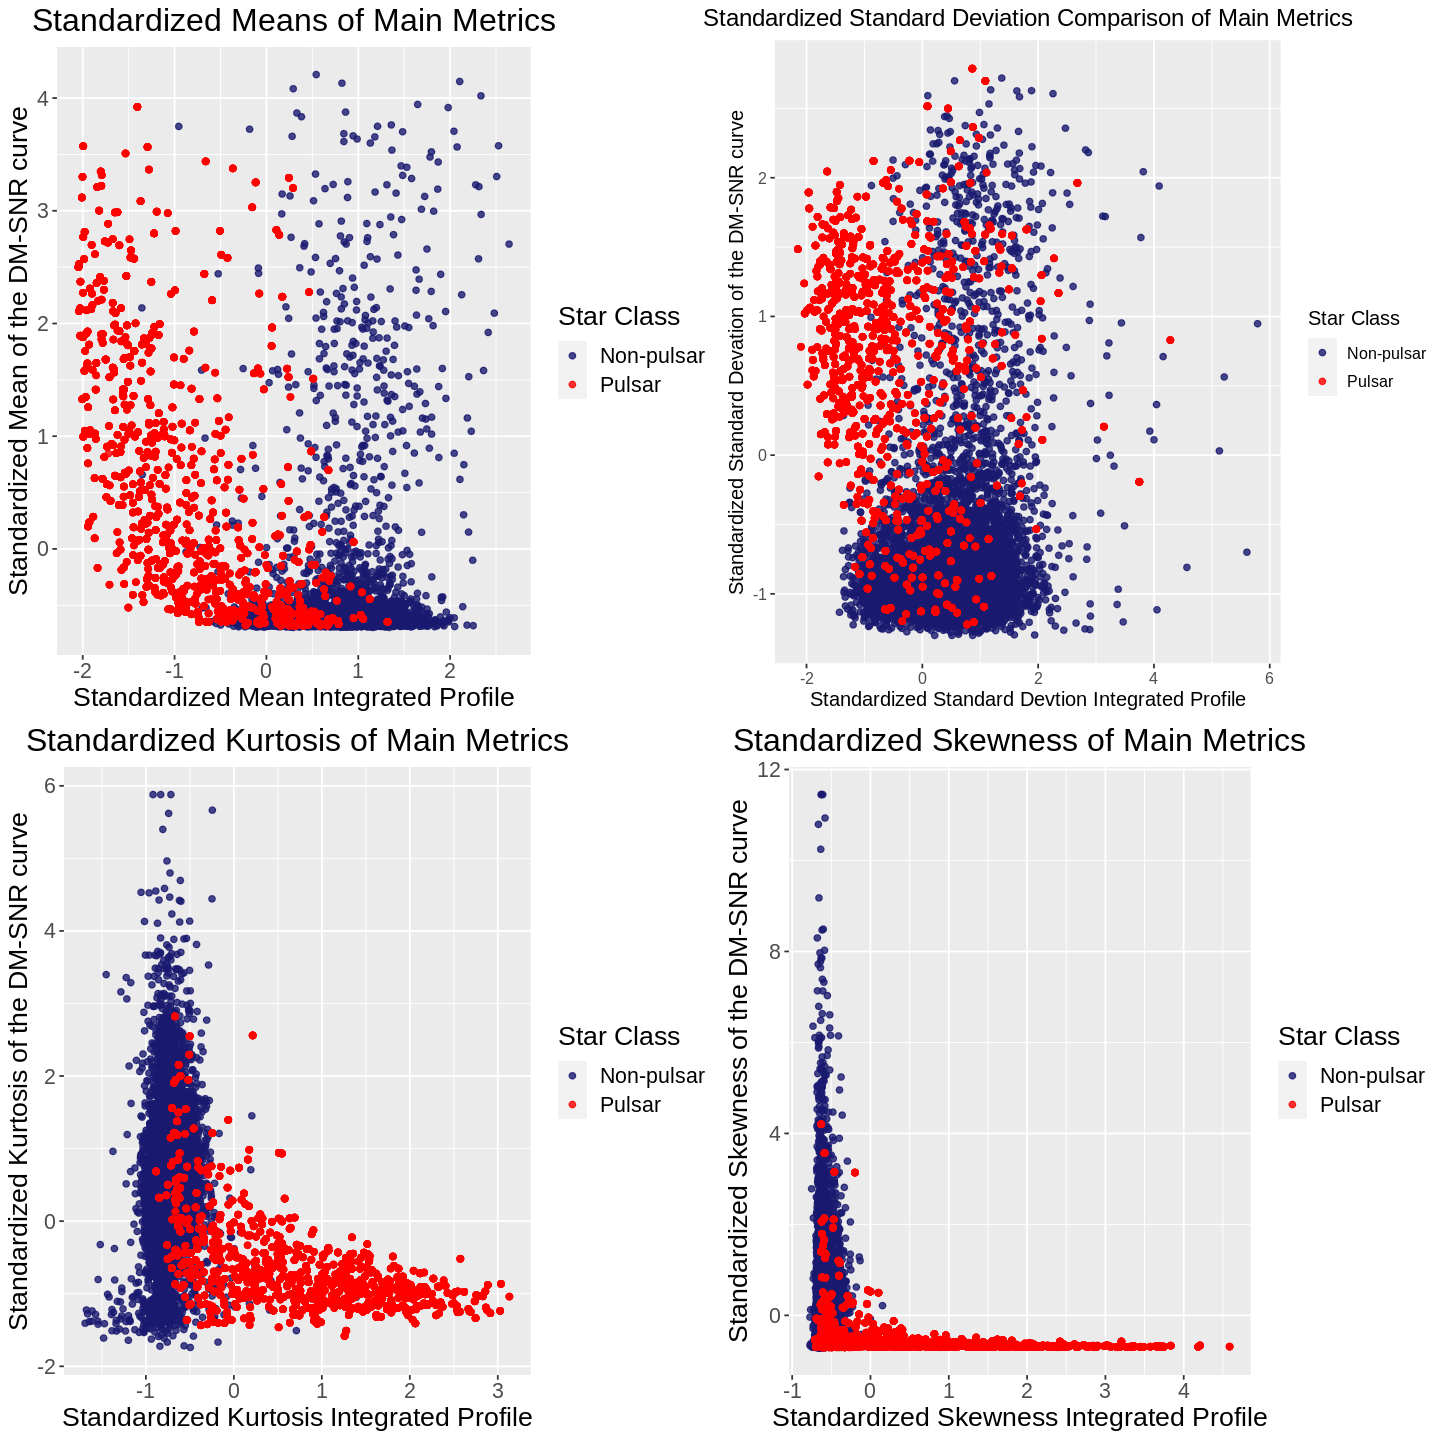

In [100]:
#Visualization for each 2-D pairing, as shown in class
mean_scaled_vis = ggplot(scaled_pulsar_train, aes(x = mean_prof, y = mean_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Mean Integrated Profile", y = "Standardized Mean of the DM-SNR curve",
           color = "Star Class", title = "Standardized Means of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
# mean_scaled_vis

sd_scaled_vis = ggplot(scaled_pulsar_train, aes(x = sd_prof, y = sd_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Standard Devtion Integrated Profile",
         y = "Standardized Standard Devation of the DM-SNR curve",
           color = "Star Class", 
         title = "Standardized Standard Deviation Comparison of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 12), plot.title = element_text(hjust = 0.5))
# sd_scaled_vis

kurt_scaled_vis = ggplot(scaled_pulsar_train, aes(x = kurt_prof, y = kurt_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Kurtosis Integrated Profile",
         y = "Standardized Kurtosis of the DM-SNR curve",
           color = "Star Class", title = "Standardized Kurtosis of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
# kurt_scaled_vis

skew_scaled_vis = ggplot(scaled_pulsar_train, aes(x = skew_prof, y = skew_DMSNR, color = target_class)) +
    geom_point(alpha = 0.8) +
    labs(x = "Standardized Skewness Integrated Profile",
         y = "Standardized Skewness of the DM-SNR curve",
           color = "Star Class", title = "Standardized Skewness of Main Metrics") +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
# skew_scaled_vis
options(repr.plot.width = 12, repr.plot.height = 12)
grid.arrange(mean_scaled_vis, sd_scaled_vis, kurt_scaled_vis, skew_scaled_vis,
           nrow = 2, ncol = 2)
# !!! plots side-by-side

## Models
### Means Model

We created a scaled recipe to predict the target class based on the mean of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 



In [60]:
options(repr.plot.width = 7, repr.plot.height = 7)
mean_recipe_train <-recipe(target_class~mean_prof+mean_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_mean_train <- bake(mean_recipe_train, scaled_pulsar_train)

mean_recipe_test <- recipe(target_class~ mean_prof + mean_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_mean_test <- bake(mean_recipe_train, scaled_pulsar_test)
set.seed(781)
gridvals = tibble(neighbors = seq(1,20))
mean_vfold <- vfold_cv(scaled_mean_train, v = 5, strata = target_class)
knn_spec = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
    set_engine("kknn") %>% 
    set_mode("classification") 

In [15]:
set.seed(781)
mean_fit <- workflow() %>%
    add_recipe(mean_recipe_train) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = mean_vfold, grid = gridvals)%>%
    collect_metrics()

A KNN accuracy plot was visualized to display the accuracy of the mean predictor at each value of K.  This was done to find the best K value.


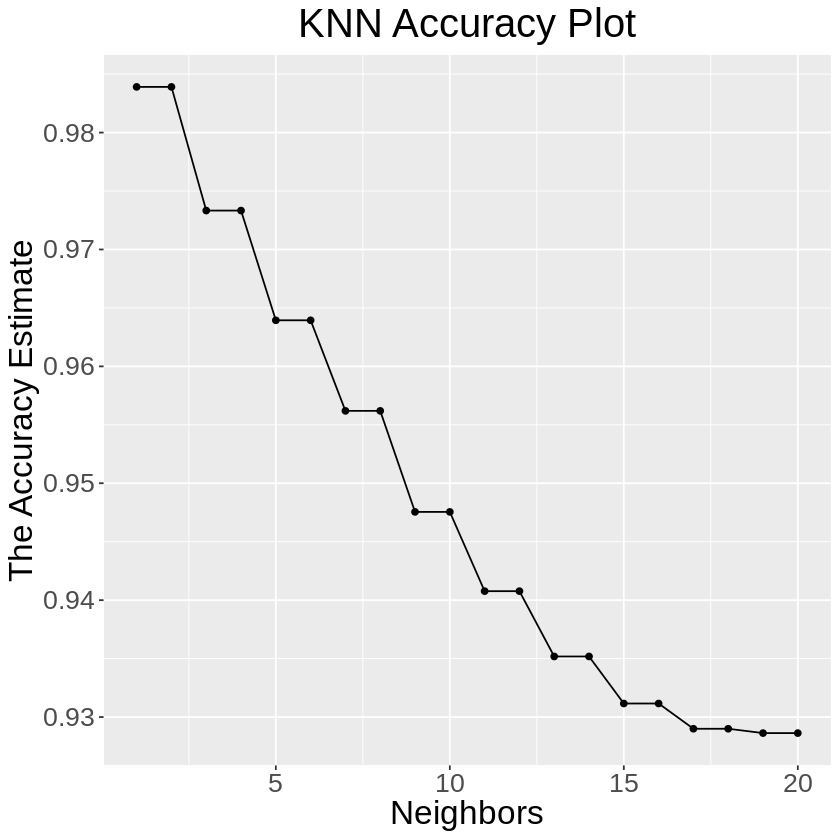

In [61]:
meanFitAccuracy <- filter(mean_fit, .metric == "accuracy")

accuracy_plot_mean <- ggplot(meanFitAccuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "The Accuracy Estimate", title = "KNN Accuracy Plot")+
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
accuracy_plot_mean

In [17]:
BestKaccuracyMean <- meanFitAccuracy %>%
    arrange(desc(mean))%>%
    slice(1)

#### Table !!! - Best Mean K Value

In [101]:
BestKaccuracyMean

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9839072,5,0.0008014114,Model01


### Standard Deviation Model

We created a scaled recipe to predict the target class based on the standard deviation of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 

In [19]:
sd_recipe_train = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_sd_train = bake(sd_recipe_train, scaled_pulsar_train)

sd_recipe_test = recipe(target_class ~ sd_prof + sd_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_sd_test = bake(sd_recipe_test, scaled_pulsar_test)

set.seed(781)
sd_vfold = vfold_cv(scaled_sd_train, v = 5, strata = target_class)   

In [22]:
set.seed(781)
sd_fit = workflow() %>% 
    add_recipe(sd_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = sd_vfold, grid = gridvals) %>% 
    collect_metrics() 

A KNN accuracy plot was visualized to display the accuracy of the standard deviation predictor at each value of K.  This was done to find the best K value.


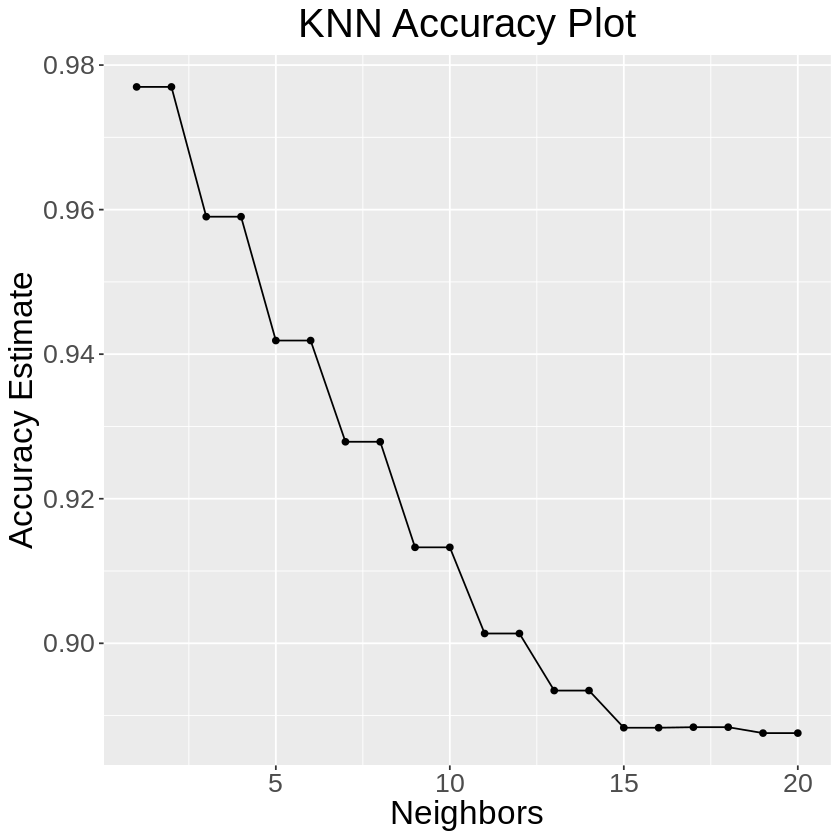

In [62]:
sdFitAccuracy = filter(sd_fit, .metric == "accuracy")

ACC_plot_SD = ggplot(sdFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + 
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_SD

In [24]:
BestKaccuracySD <- sdFitAccuracy %>%
    arrange(desc(mean))%>%
    slice(1)

#### Table !!! - Best Standard Deviation K Value

In [102]:
BestKaccuracySD

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9769779,5,0.00151582,Model01


### Skewness Model

We created a scaled recipe to predict the target class based on the skewness of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 

In [103]:
skew_recipe_train = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_skew_train = bake(skew_recipe_train, scaled_pulsar_train)

skew_recipe_test = recipe(target_class ~ skew_prof + skew_DMSNR, data = scaled_pulsar_test) %>%
                    prep()
scaled_skew_test = bake(skew_recipe_test, scaled_pulsar_test)

set.seed(781)
skew_vfold = vfold_cv(scaled_skew_train, v = 5, strata = target_class)

In [29]:
set.seed(781)
skew_fit = workflow() %>%
    add_recipe(skew_recipe_train) %>%
    add_model(knn_spec) %>%
    tune_grid(resamples = skew_vfold, grid = gridvals) %>%
    collect_metrics()

A KNN accuracy plot was visualized to display the accuracy of the skewness predictor at each value of K.  This was done to find the best K value.


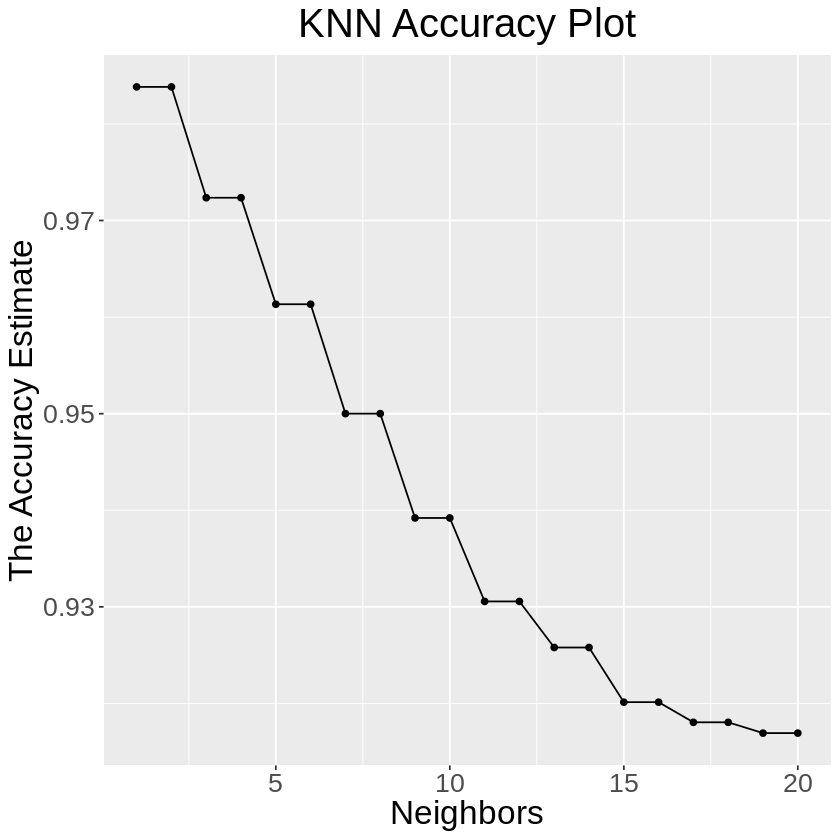

In [63]:
skewFitAccuracy <- filter(skew_fit, .metric == "accuracy")

accuracy_plot_skew <- ggplot(skewFitAccuracy, aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbors", y = "The Accuracy Estimate", title = "KNN Accuracy Plot")+
    theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
accuracy_plot_skew

In [31]:
BestKaccSkew = skewFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)

#### Table 15 - Best Skewness K Value

In [104]:
BestKaccSkew

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9838334,5,0.001706795,Model01


### Kurtosis Model

We created a scaled recipe to predict the target class based on the kurtosis of the integrated profile and DM-SNR curve. 
The seed was randomly selected to be 781. For each of these different sets of variables, we created a K-nearest-neighbours model on the training set.  Five-fold-cross-validation was used to tune the hyperparameter K across the values 1 to 20. 

In [33]:
kurt_recipe_train = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_kurt_train = bake(kurt_recipe_train, scaled_pulsar_train)

kurt_recipe_test = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_kurt_test = bake(kurt_recipe_test, scaled_pulsar_test)

set.seed(781)
kurt_vfold = vfold_cv(scaled_kurt_train, v = 5, strata = target_class)

In [36]:
set.seed(781)
kurt_fit = workflow() %>% 
    add_recipe(kurt_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = kurt_vfold, grid = gridvals) %>% 
    collect_metrics()

A KNN accuracy plot was visualized to display the accuracy of the kurtosis predictor at each value of K.  This was done to find the best K value.


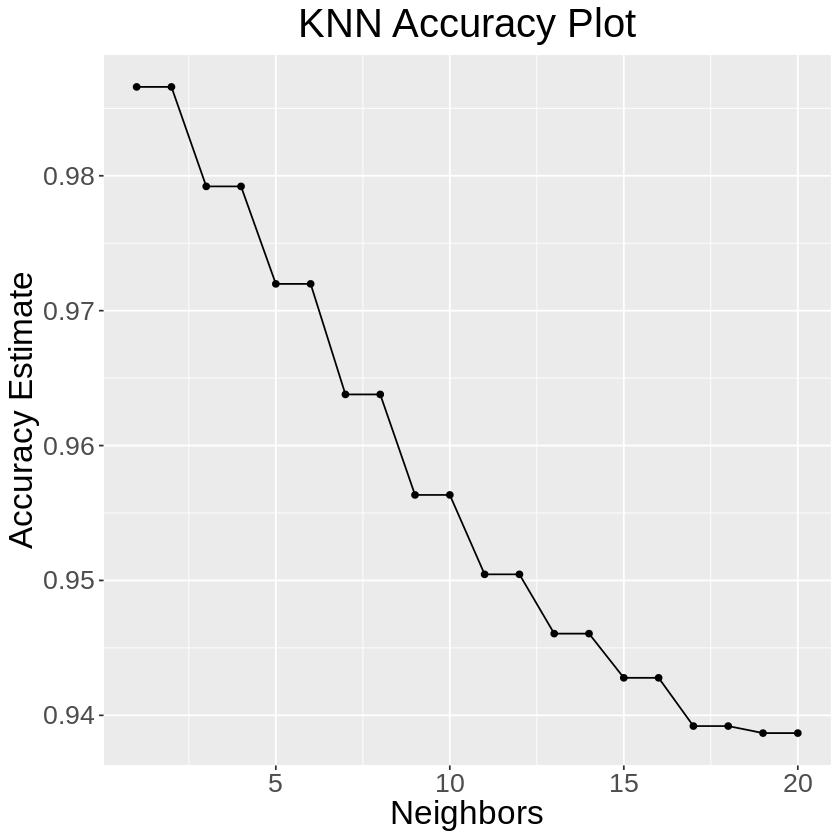

In [64]:
kurtFitAccuracy = filter(kurt_fit, .metric == "accuracy")

ACC_plot_kurt = ggplot(kurtFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_kurt

In [38]:
BestKaccKurt = kurtFitAccuracy %>%
    arrange(desc(mean)) %>%
    slice(1)

#### Table 18 - Best Kurtosis K Value

In [105]:
BestKaccKurt

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.986589,5,0.000677801,Model01


### Integrated Profile Model

We created a scaled recipe to predict the target class of the integrated profile model using 4 predictors (mean, standard deviation, kurtosis and skewness).  The seed was randomly selected to be 781. A 5 fold cross validation was done on the scaled training data.

In [40]:
profile_recipe_train = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_train) %>% 
                    prep()
scaled_profile_train = bake(profile_recipe_train, scaled_pulsar_train)

profile_recipe_test = recipe(target_class ~ mean_prof + sd_prof + kurt_prof + skew_prof, data = scaled_pulsar_test) %>% 
                    prep()
scaled_profile_test = bake(profile_recipe_test, scaled_pulsar_test)

set.seed(781)
profile_vfold = vfold_cv(scaled_profile_train, v = 5, strata = target_class)

In [43]:
set.seed(781)
profile_fit = workflow() %>% 
    add_recipe(profile_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = profile_vfold, grid = gridvals) %>% 
    collect_metrics()


A KNN accuracy plot was visualized to display the accuracy of the integrated profile at each value of K.  This was done to find the best K value.


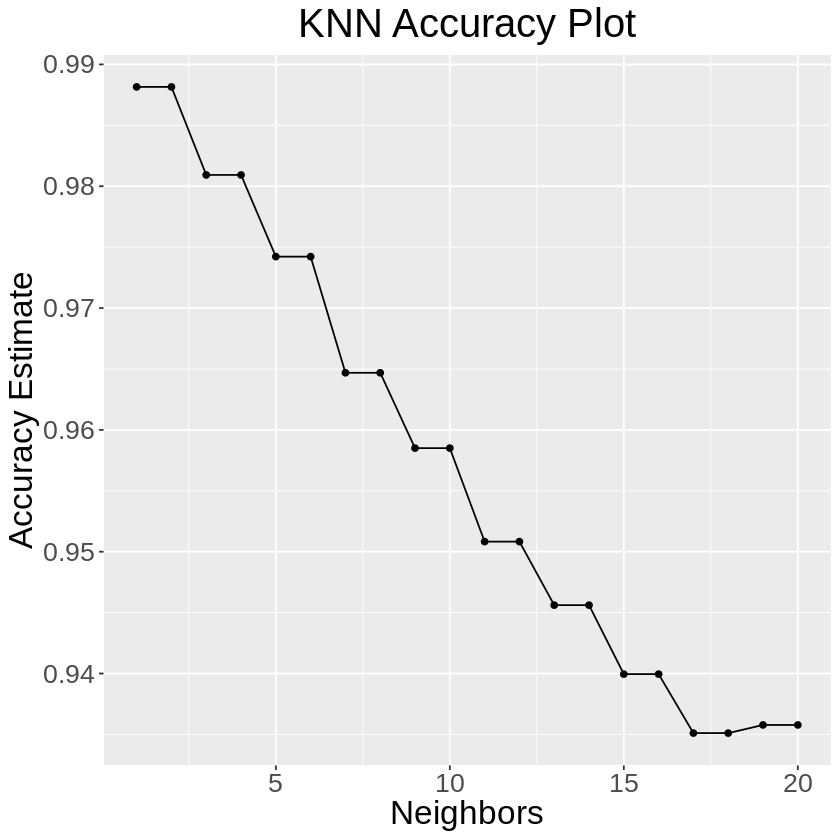

In [65]:
ProfFitAccuracy = filter(profile_fit, .metric == "accuracy")

ACC_plot_prof = ggplot(ProfFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_prof

In [45]:
BestKaccProf = ProfFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)

#### Table 21 - Best Integrated Profile K Value

In [106]:
BestKaccProf

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9881544,5,0.001117994,Model01


### DMSNR Model

We created a scaled recipe to predict the target class of the DMSNR model using 4 predictors (mean, standard deviation, kurtosis and skewness).  The seed was randomly selected to be 781. A 5 fold cross validation was done on the scaled training data. 


In [47]:
DMSNR_recipe_train = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_train) %>% 
                    prep()
scaled_DMSNR_train = bake(DMSNR_recipe_train, scaled_pulsar_train)

DMSNR_recipe_test = recipe(target_class ~ mean_DMSNR + sd_DMSNR + kurt_DMSNR + skew_DMSNR, data = scaled_pulsar_test) %>% 
                    prep()
scaled_DMSNR_test = bake(DMSNR_recipe_test, scaled_pulsar_test)

set.seed(781)
DMSNR_vfold = vfold_cv(scaled_DMSNR_train, v = 5, strata = target_class)

In [50]:
set.seed(781)
DMSNR_fit = workflow() %>% 
    add_recipe(DMSNR_recipe_train) %>% 
    add_model(knn_spec) %>% 
    tune_grid(resamples = DMSNR_vfold, grid = gridvals) %>% 
    collect_metrics()


A KNN accuracy plot was visualized to display the accuracy of the DM-SNR model at each value of K.  This was done to find the best K value.


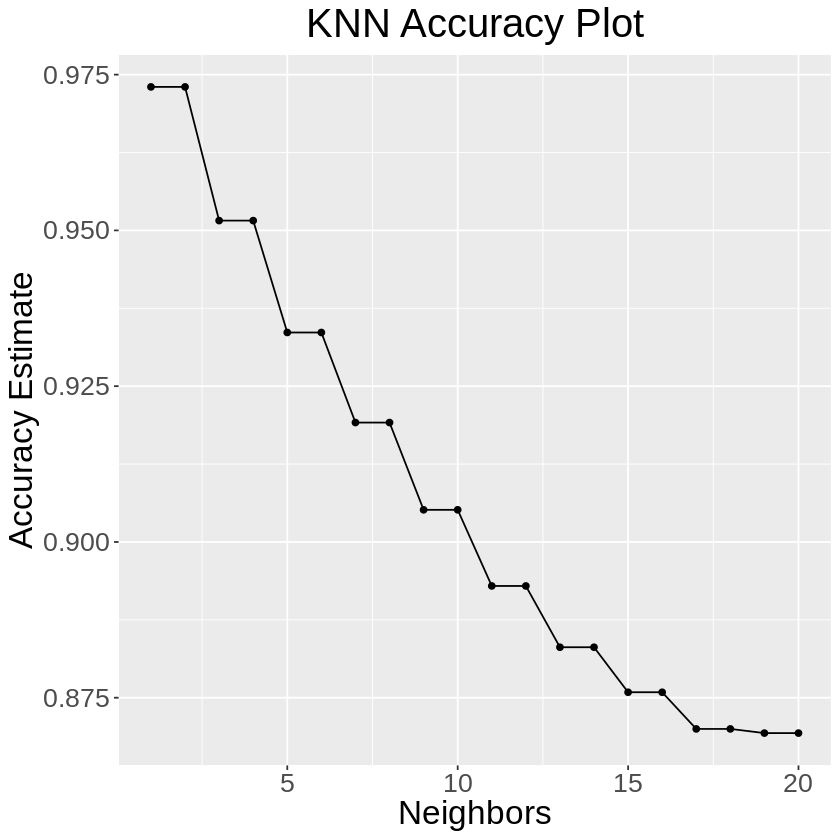

In [66]:
DMSNRFitAccuracy = filter(DMSNR_fit, .metric == "accuracy")

ACC_plot_DMSNR = ggplot(DMSNRFitAccuracy, aes(x = neighbors, y = mean)) +
  geom_point() + geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "KNN Accuracy Plot") +
  theme(plot.title = element_text(hjust = 0.5), text = element_text(size = 20))
ACC_plot_DMSNR

In [52]:
BestKaccDMSNR = DMSNRFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(1)

#### Table 24 - Best DMSNR K Value

In [107]:
BestKaccDMSNR

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9730301,5,0.001561857,Model01


A tibble was created to display the accuracies and best K value on the train set for all of our models. The accuracy was compared in order to select the best group of predictor variables.


In [54]:
TrainAccuracies = tibble(rbind(BestKaccuracyMean, BestKaccuracySD, BestKaccSkew, 
                               BestKaccKurt, BestKaccProf, BestKaccDMSNR))

AlsoBestKurtK = kurtFitAccuracy %>% 
    arrange(desc(mean)) %>% 
    slice(2)
AlsoBestKurtK

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.986589,5,0.000677801,Model02


#### Table 25 - Accuracies of all models

In [108]:
TrainAccuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9839072,5,0.0008014114,Model01
1,accuracy,binary,0.9769779,5,0.0015158202,Model01
1,accuracy,binary,0.9838334,5,0.0017067954,Model01
1,accuracy,binary,0.9865890,5,0.0006778010,Model01
1,accuracy,binary,0.9881544,5,0.0011179943,Model01
1,accuracy,binary,0.9730301,5,0.0015618574,Model01


## Performance on the test set

Comparing the accuracies of the best K values of the, we see that $k=1$ and $k=2$ are the best values in terms of accuracy (they tie exactly).  Since $k=1$ is associated with overfitting, we will use $k=2$ in an attempt to alleviate this issue

Once the best K was found from all of the models, we compared their accuracies in order to select the best predictor group. From the Kurtosis Model, we determined that K= 2 was the best K value. Using $K = 2$, we ran the model on the testing data in order to generate the predictions and calculate the accuracy of the model. To visualize the decisions made by the KNN classifier about whether the stars were pulsars or not, we created a plot with background colour to demonstrate which regions of the possible predictor values would have data points classified as a pulsar or a non pulsar. 

In [90]:
## using kurt_recipe_train
kurt_recipe_best = recipe(target_class ~ kurt_prof + kurt_DMSNR, data = pulsar_test_noNA) %>% 
    step_scale(all_predictors()) %>% 
    step_center(all_predictors())
knn_spec_best = nearest_neighbor(weight_func = "rectangular", neighbors = 2) %>% 
    set_engine("kknn") %>% 
    set_mode("classification")

In [91]:
kurt_best_fit = workflow() %>% 
    add_recipe(kurt_recipe_best) %>% 
    add_model(knn_spec_best) %>%
    fit(data = scaled_pulsar_train)

In [92]:
kurt_pulsar_preds = predict(kurt_best_fit, scaled_pulsar_test) %>% 
    bind_cols(scaled_pulsar_test) %>% 
    select(kurt_prof, kurt_DMSNR, target_class, .pred_class)

kurt_prof,kurt_DMSNR,target_class,.pred_class
<dbl>,<dbl>,<fct>,<fct>
-0.18496543,0.24305640,non_pulsar,pulsar
-0.49151524,-0.33098399,non_pulsar,non_pulsar
-0.22459219,-0.19184137,non_pulsar,non_pulsar
-0.24399215,0.02768594,non_pulsar,non_pulsar
0.08090689,-0.06350674,non_pulsar,pulsar
-0.32417289,-0.53718862,non_pulsar,non_pulsar


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6119722
kap,binary,0.1752835


            Truth
Prediction   non_pulsar pulsar
  non_pulsar        994      8
  pulsar            718    151

#### Table !!! - Predictions with Best Model

In [109]:
head(kurt_pulsar_preds)

kurt_prof,kurt_DMSNR,target_class,.pred_class
<dbl>,<dbl>,<fct>,<fct>
-0.18496543,0.24305640,non_pulsar,pulsar
-0.49151524,-0.33098399,non_pulsar,non_pulsar
-0.22459219,-0.19184137,non_pulsar,non_pulsar
-0.24399215,0.02768594,non_pulsar,non_pulsar
0.08090689,-0.06350674,non_pulsar,pulsar
-0.32417289,-0.53718862,non_pulsar,non_pulsar


#### Table !!! - Best Model Test Set Metrics

In [110]:
kurt_pulsar_predmetrics = metrics(kurt_pulsar_preds, truth = target_class, estimate = .pred_class)
kurt_pulsar_predmetrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6119722
kap,binary,0.1752835


#### Table !!! - Best Model Confusion Matrix

In [111]:
kurt_pulsar_conf_mat = conf_mat(kurt_pulsar_preds, truth = target_class, estimate = .pred_class)
kurt_pulsar_conf_mat

            Truth
Prediction   non_pulsar pulsar
  non_pulsar        994      8
  pulsar            718    151

Note **The following code does not work yet**

Class,kurt_prof,kurt_DMSNR
<fct>,<dbl>,<dbl>
non_pulsar,-1.619067,-2.37847
non_pulsar,-1.526465,-2.37847
non_pulsar,-1.433863,-2.37847
⋮,⋮,⋮
pulsar,7.363355,4.527688
pulsar,7.455957,4.527688
pulsar,7.548560,4.527688


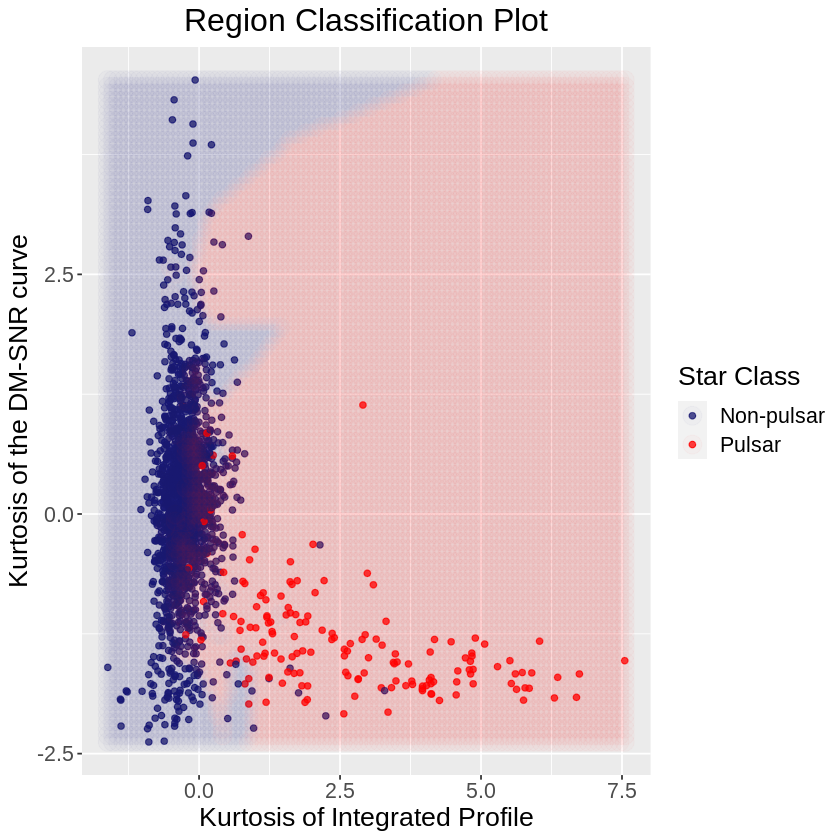

In [95]:
are_grid <- seq(min(scaled_kurt_test$kurt_prof), max(scaled_kurt_test$kurt_prof), length.out = 100)
smo_grid <- seq(min(scaled_kurt_test$kurt_DMSNR), max(scaled_kurt_test$kurt_DMSNR), length.out = 100)
asgrid <- as_tibble(expand.grid(kurt_prof = are_grid, kurt_DMSNR = smo_grid))

knnPredGrid <- predict(kurt_best_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Class = .pred_class)
prediction_table
# !!! Where is the null coming from
# !!! Why does it do so poorly on the test set
# !!! Why on not scaled data
area_plot = ggplot() +
    geom_point(data = scaled_kurt_test, mapping = aes(x = kurt_prof, y = kurt_DMSNR, color = target_class), alpha = 0.75) +
    geom_point(data = prediction_table, mapping = aes(x = kurt_prof, y = kurt_DMSNR, color = Class), alpha = 0.02, size = 5.) +
    labs(x = "Kurtosis of Integrated Profile",
         y = "Kurtosis of the DM-SNR curve",
         title = "Region Classification Plot",
         color = "Star Class") +
#     theme_minimal() +
    scale_color_manual(labels = c("Non-pulsar", "Pulsar"), values = c("midnightblue", "red")) +
    theme(text = element_text(size = 16), plot.title = element_text(hjust = 0.5))
area_plot

## Discussion and Conclusions

The cross-validation implementation across all of our variable pairings shows us the Kurtosis pairing on the Integrated Profile and the DM-SNR curve is the best predictor set. The k value it gives us is a tie between one and two neighbours. The accuracy for both of these was 98.6589%, which was slightly worse than the model from the set which contained all of the Integrated Profile statistics. We chose the Kurtosis model because the slight gap was under 0.2% and it has two fewer variables than the other model. This makes it much easier to visualize and follows the parsimonious principle.

The results from Kurtosis pairing with k = 2 on the test set yield an accuracy rate of 61.19722%. This is a sharp decrease from the performance on the training set, which is strong evidence of overfitting, as very low values of k tend to indicate that the model is very reliant on the individual data points of the training set and not information from any trends that may be present in the data. Based on our visual analysis, we expected to find a much better model. The imbalance in the data appears to have a large impact on the model, as the confusion matrix figure displayed many non-pulsar stars that were still classified as pulsars by the final model. This shows that upsampling, although it attempted to alleviate the issue of imbalance, has failed to completely negate the imbalance in this data.

The findings show that the basic KNN models do not have strong predictive power. If the model had been more successful, scientists could have automated the pulsar detection process, which would facilitate future research on the stars. A successful model also could have eliminated the need to collect so much data on these stars. What this failure shows scientists is that it is possible the Integrated Profile, DM-SNR curve, and the relationship between them may not be the best quantitative indicators of a pulsar. This result leads to scientists looking for other numerical values to collect in order to construct models using those instead (or at least other variable combinations that we did not test). It is also possible that KNN should be discarded for future model creation if overfitting persists.

In future work, astronomers can ask why might these variables fail to make a good prediction model. This may lead to finding correlations between other quantifiable characteristics of stars and whether or not it is a pulsar. Another question astronomers could ask with a successful result is if the model could be extended to find areas in the sky where pulsars are more common. If clusters could be found, it may lead to more information as to what environments they form and how they gravitationally interact with one another. 


## References

Cofield, C. (2016, April 22). What Are Pulsars? Space.com. 
https://www.space.com/32661-pulsars.html. 

Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & 
Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17=

Hobbs, M. (2020, November 17). An Introduction to Pulsars. Australia Telescope National 
Facility. https://www.atnf.csiro.au/outreach/education/everyone/pulsars/index.html.

Liu, K. (2017, June 26). Introduction to Pulsar, Pulsar Timing, and measuring of Pulse Time-of-Arrivals. Personal Collection of Kuo Liu, CIEP, Sèvres, France. 

Lounge, C.-learning. (2020, August 26). Predicting Pulsar Star. Kaggle. 
https://www.kaggle.com/colearninglounge/predicting-pulsar-starintermediate?select=pulsar_data_train.csv. 

Rowan, L., & Coontz, R. (2004, April 23). The Strange and Twisted World of Pulsars. 
Science. https://science.sciencemag.org/content/304/5670/531.  

Lyon, R. (2017, February 14). HTRU2 Data Set. UCI Machine Learning Repository. https://archive.ics.uci.edu/ml/datasets/HTRU2

Swinburne University of Technology. (2020). Pulsar Dispersion Measure. COSMOS. https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure

The University of Sheffield. (n.d.). L14 Signal-to-Noise. PHY217 Observational Techniques for Astronomers. http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L14/index.html